In [18]:
import os, psutil

# Determine number of available (idle) cores
IDLE_THRESHOLD = 20.0  # percent
cpu_usages = psutil.cpu_percent(percpu=True, interval=1)
available_cores = sum(usage < IDLE_THRESHOLD for usage in cpu_usages)
available_cores = max(1, available_cores) - 4 # At least 1

available_cores = os.cpu_count()

import mplfinance
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# Stable-Baselines3 imports
from stable_baselines3 import PPO,A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import SubprocVecEnv  # Use this instead of DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
#from stable_baselines3.common.policies import ActorCriticPolicy
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.ppo_mask import MaskablePPO

# Gymnasium (updated from Gym)
import gymnasium as gym
from gymnasium import Env,Wrapper
from gymnasium.spaces import Discrete, Box


In [19]:
# Load Data
df = pd.read_csv("MGOL.csv")  # Replace with actual file
df['datetime'] = pd.to_datetime(df['datetime'], format='%m/%d/%y %H:%M')
df.set_index('datetime', inplace=True)

In [20]:
df.index = df.index + pd.Timedelta(hours=3)
df.index.name = 'Date'
df = df.drop(columns=['symbol', 'frame'])
df = df.iloc[:10]  # Select the first 30 rows
df_original = df
df = df[["close"]]

In [ ]:
import importlib
import trading_env_sb3_ver2c
importlib.reload(trading_env_sb3_ver2c)
from trading_env_sb3_ver2c import TradingEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, VecNormalize
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.ppo_mask import MaskablePPO

# Create directories for saving
log_dir = "./tensorboard_logs/"
os.makedirs(log_dir, exist_ok=True)

num_cpu = 1

def make_env():
    env = TradingEnv(df)  # Initialize env
    check_env(env, warn=True)
    return env

# Create parallel environments using SubprocVecEnv
env = SubprocVecEnv([make_env for _ in range(num_cpu)])

# Wrap with VecMonitor first
env = VecMonitor(env)

# Wrap with VecNormalize
env = VecNormalize(env)

model = MaskablePPO(MaskableActorCriticPolicy, env, verbose=1, tensorboard_log="./tensorboard_logs/", )
model.learn(total_timesteps=100000, tb_log_name="sb3_ppo_debug")


Using cpu device
Logging to ./tensorboard_logs/sb3_ppo_debug_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | -0.0391  |
| time/              |          |
|    fps             | 1763     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | -0.0346     |
| time/                   |             |
|    fps                  | 1544        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015041508 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.681      |
|    expl

In [67]:
import importlib
import trading_env_sb3_ver2c
importlib.reload(trading_env_sb3_ver2c)
from trading_env_sb3_ver2c import TradingEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, VecNormalize
from stable_baselines3.common.callbacks import BaseCallback
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.ppo_mask import MaskablePPO
import os
import datetime

# Import and reload the callbacks
import debug_eval_callback
importlib.reload(debug_eval_callback)
from debug_eval_callback import DebugEvalCallback

import learning_progress_callback
importlib.reload(learning_progress_callback)
from learning_progress_callback import LearningProgressCallback

# Create directories for saving
log_dir = "./tensorboard_logs/PPO_Trading_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs(log_dir, exist_ok=True)

num_cpu = 1

def make_env():
    env = TradingEnv(df)  # Initialize env
    check_env(env, warn=True)
    return env

def make_eval_env():
    env = TradingEnv(df)  # Initialize env
    check_env(env, warn=True)
    return env

# Create parallel environments for training
train_env = SubprocVecEnv([make_env for _ in range(num_cpu)])
train_env = VecMonitor(train_env)
train_env = VecNormalize(train_env, training=True, norm_reward=True, norm_obs=True)

# Create parallel environments for evaluation
eval_env = SubprocVecEnv([make_eval_env for _ in range(1)])
eval_env = VecMonitor(eval_env)
eval_env = VecNormalize(eval_env, training=False, norm_reward=False)

# Create evaluation callback
eval_callback = DebugEvalCallback(
    eval_env,
    best_model_save_path=log_dir,
    log_path=log_dir,
    eval_freq=5000,  # Evaluate every 5000 steps
    deterministic=True,
    render=False,
    n_eval_episodes=10,
    verbose=1
)

# Create learning progress callback
learning_progress_callback = LearningProgressCallback()

# Create model
model = MaskablePPO(
    MaskableActorCriticPolicy,
    train_env,
    verbose=0,  # Set to 1 for progress output
    tensorboard_log=log_dir,
    ent_coef=0.001,
    gamma=0.99,
    gae_lambda=0.95,
    n_steps=64,
    clip_range=0.1,
    clip_range_vf=0.1,
    n_epochs=20,
    batch_size=32,
    max_grad_norm=0.5,
    vf_coef=0.5,
    normalize_advantage=False,
    policy_kwargs=dict(
        net_arch=dict(pi=[256, 256], vf=[256, 256])
    )
)

# Train the model
model.learn(
    total_timesteps=1000,
    callback=[eval_callback, learning_progress_callback],
    log_interval=1
)

# Save final model and normalization stats
model.save(os.path.join(log_dir, "final_model"))
train_env.save(os.path.join(log_dir, "vec_normalize.pkl"))

Eval callback initialized!

New best reward: -0.0518 at episode 1

Training progress at step 100:
Learning rate: 0.000300
Entropy: 0.6904

Recent (last 10) episodes:
Mean reward: -0.0518
Std reward: 0.0000
Min reward: -0.0518
Max reward: -0.0518

New best reward: -0.0504 at episode 2

New best reward: -0.0135 at episode 3

Training progress at step 200:
Learning rate: 0.000300
Entropy: 0.6578

Recent (last 10) episodes:
Mean reward: -0.0386
Std reward: 0.0177
Min reward: -0.0518
Max reward: -0.0135

Training progress at step 300:
Learning rate: 0.000300
Entropy: 0.6424

Recent (last 10) episodes:
Mean reward: -0.0343
Std reward: 0.0171
Min reward: -0.0518
Max reward: -0.0135

Training progress at step 400:
Learning rate: 0.000300
Entropy: 0.6890

Recent (last 10) episodes:
Mean reward: -0.0311
Std reward: 0.0152
Min reward: -0.0518
Max reward: -0.0135

Training progress at step 500:
Learning rate: 0.000300
Entropy: 0.6931

Recent (last 10) episodes:
Mean reward: -0.0298
Std reward: 0.0

In [87]:
def test_trading_model(model, vec_norm_path, num_episodes=3, render=False):
    """Test the trained trading model with a single DummyVecEnv and return signals.
    
    Args:
        model: Trained PPO model
        vec_norm_path: Path to saved VecNormalize stats (optional)
        num_episodes: Number of episodes to run
        render: Whether to print debug info
        
    Returns:
        tuple: (all_episodes_results, first_episode_signals)
            all_episodes_results: dict containing results from all episodes
            first_episode_signals: dict with 'buy_signals' and 'sell_signals' from first episode
    """
    # Create a single test environment
    def make_test_env():
        def _init():
            env = TradingEnv(df)
            return ActionMasker(env, mask_fn)
        return _init

    # Initialize results
    all_episodes_results = {
        'episode_rewards': [],
        'all_buy_signals': [],
        'all_sell_signals': [],
        'actions': [],
        'timesteps': []
    }
    
    # Store first episode signals separately
    first_episode_signals = {
        'buy_signals': [],
        'sell_signals': []
    }
    
    # Set model to evaluation mode
    model.policy.eval()
    
    # Create environment
    env = DummyVecEnv([make_test_env()])

    # Load saved normalization stats instead of creating new ones
    if vec_norm_path:
        env = VecNormalize.load(vec_norm_path, env)
        env.training = False  # Don't update stats during testing
        env.norm_reward = False  # Don't normalize rewards during testing
    else:
        # If no saved stats, create new normalization (not recommended for testing)
        env = CustomVecNormalize(
            env,
            norm_obs=True,
            norm_reward=True,
            clip_obs=10.0,
            clip_reward=10.0,
            gamma=0.99,
            training=False
        )
    
    try:
        for episode in range(num_episodes):
            obs = env.reset()
            done = False
            episode_reward = 0
            step = 0
            
            # Lists to store signals for current episode
            episode_buy_signals = []
            episode_sell_signals = []
            
            if render:
                print(f"\n=== Episode {episode + 1} ===")
                print(f"Initial observation: {obs}")
            
            while not done and step < len(df) - 1:
                try:
                    # Get action mask from the environment
                    action_mask = env.envs[0].env.get_action_mask()
                    
                    # Get action from model
                    with torch.no_grad():
                        obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=model.device)
                        dist = model.policy.get_distribution(obs_tensor)
                        masked_logits = dist.distribution.logits + torch.log(
                            torch.as_tensor(action_mask, dtype=torch.float32, device=model.device) + 1e-8
                        )
                        action = torch.argmax(masked_logits).item()
                    
                    # Step environment
                    new_obs, reward, done, info = env.step([action])
                    
                    # Track signals
                    current_step = info[0].get('current_step', step)
                    current_time = df.index[current_step]
                    
                    if action == 1:  # BUY
                        episode_buy_signals.append(current_time)
                        if render:
                            print(f"Step {step}: BUY at {df['close'].iloc[current_step]:.4f}")
                    elif action == 2:  # SELL
                        episode_sell_signals.append(current_time)
                        if render:
                            print(f"Step {step}: SELL at {df['close'].iloc[current_step]:.4f}")
                    
                    # Store results
                    all_episodes_results['actions'].append(action)
                    all_episodes_results['timesteps'].append(current_step)
                    episode_reward += reward[0] if isinstance(reward, np.ndarray) else reward
                    obs = new_obs
                    step += 1
                    
                except Exception as e:
                    print(f"Error at step {step}: {str(e)}")
                    done = True
                    break
            
            # Store signals for this episode
            all_episodes_results['all_buy_signals'].append(episode_buy_signals)
            all_episodes_results['all_sell_signals'].append(episode_sell_signals)
            all_episodes_results['episode_rewards'].append(episode_reward)
            
            # Store first episode signals separately
            if episode == 0:
                first_episode_signals['buy_signals'] = episode_buy_signals
                first_episode_signals['sell_signals'] = episode_sell_signals
            
            if render:
                print(f"Episode {episode + 1} completed with reward: {episode_reward:.2f}")
                print(f"  Buy signals: {len(episode_buy_signals)}")
                print(f"  Sell signals: {len(episode_sell_signals)}")
            
            # Reset for next episode
            env.reset()
    
    finally:
        # Cleanup
        env.close()
    
    # Print summary
    print("\n=== Test Results ===")
    print(f"Episodes: {num_episodes}")
    if all_episodes_results['episode_rewards']:
        print(f"Mean reward: {np.mean(all_episodes_results['episode_rewards']):.2f} ± {np.std(all_episodes_results['episode_rewards']):.2f}")
    
    # Print signal counts for all episodes
    for i in range(num_episodes):
        print(f"Episode {i+1}: {len(all_episodes_results['all_buy_signals'][i])} buy signals, {len(all_episodes_results['all_sell_signals'][i])} sell signals")
    
    return first_episode_signals

# Then test the model
# Test the model and get results
first_episode_signals = test_trading_model(
    PPO.load("sb3_ppo_model.zip"),
    vec_norm_path="vecnormalize.pkl",
    num_episodes=3, 
    render=True
)

# Access the signals from the first episode
buy_signals = first_episode_signals['buy_signals']
sell_signals = first_episode_signals['sell_signals']

print("\nFirst episode buy signals:", buy_signals)
print("First episode sell signals:", sell_signals)


=== Episode 1 ===
Initial observation: [[ 2.0362396e+00 -9.0626061e-01  8.0337775e-01  4.9388060e-01
  -1.5661801e+00  9.0771191e-06  9.0626061e-01 -9.0626061e-01]]
Step 0: BUY at 0.3386
Step 1: BUY at 0.3265
Step 2: BUY at 0.3288
Step 3: BUY at 0.3123
Episode 1 completed with reward: -0.50
  Buy signals: 4
  Sell signals: 0

=== Episode 2 ===
Initial observation: [[ 2.0362396e+00 -9.0626061e-01  8.0337775e-01  4.9388060e-01
  -1.5661801e+00  9.0771191e-06  9.0626061e-01 -9.0626061e-01]]
Step 0: BUY at 0.3386
Step 1: BUY at 0.3265
Step 2: BUY at 0.3288
Step 3: BUY at 0.3123
Episode 2 completed with reward: -0.50
  Buy signals: 4
  Sell signals: 0

=== Episode 3 ===
Initial observation: [[ 2.0362396e+00 -9.0626061e-01  8.0337775e-01  4.9388060e-01
  -1.5661801e+00  9.0771191e-06  9.0626061e-01 -9.0626061e-01]]
Step 0: BUY at 0.3386
Step 1: BUY at 0.3265
Step 2: BUY at 0.3288
Step 3: BUY at 0.3123
Episode 3 completed with reward: -0.50
  Buy signals: 4
  Sell signals: 0

=== Test Result

In [80]:
def print_env_structure(env, indent=0):
    """Recursively print the environment wrapper structure."""
    prefix = "  " * indent
    print(f"{prefix}└─ {type(env).__name__}")
    
    # Special handling for common wrapper types
    if hasattr(env, 'env'):
        print_env_structure(env.env, indent + 1)
    elif hasattr(env, 'envs') and hasattr(env.envs, '__getitem__'):
        print(f"{prefix}  └─ [0]")  # First sub-environment
        print_env_structure(env.envs[0], indent + 2)

In [ ]:
def test_agent(model, env, buy_signals, sell_signals, num_episodes=1):
    """Test function that handles action masking and tracks rewards."""
    print("Environment structure:")
    print_env_structure(env)
    
    # Helper to safely get base environment
    def get_base_env(env):
        current = env
        while True:
            if hasattr(current, 'envs') and hasattr(current.envs, '__getitem__'):
                current = current.envs[0]
            elif hasattr(current, 'env'):
                current = current.env
            else:
                return current
    
    # Get the base environment
    base_env = get_base_env(env)
    print(f"\nBase environment: {type(base_env).__name__}")
    
    # Check if environment is wrapped with VecNormalize
    vec_norm = None
    current = env
    while hasattr(current, 'env'):
        if hasattr(current, 'obs_rms'):
            vec_norm = current
            break
        current = current.env
    
    # Track rewards across all episodes
    all_episode_rewards = []
    all_episode_actions = []
    all_episode_prices = []
    
    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        current_step = 0
        episode_buys = []
        episode_sells = []
        episode_rewards = []
        episode_actions = []
        episode_prices = []
        
        print(f"\n{'='*50}")
        print(f"=== Episode {episode + 1} ===")
        print(f"{'Step':<6} {'Action':<6} {'Price':<10} {'Reward':<10} {'Cumulative':<10}")
        print("-"*45)
        
        cumulative_reward = 0
        
        while not done and current_step < len(df):
            try:
                # Get action mask from the base environment
                action_mask = np.ones(3, dtype=np.float32)
                if hasattr(base_env, 'get_action_mask'):
                    action_mask = base_env.get_action_mask()
                
                # Get action using the model's policy
                with torch.no_grad():
                    # Normalize observation if VecNormalize is used
                    if vec_norm is not None:
                        obs = vec_norm.normalize_obs(obs)
                    obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=model.device)
                    dist = model.policy.get_distribution(obs_tensor)
                    masked_logits = dist.distribution.logits + torch.log(
                        torch.as_tensor(action_mask, dtype=torch.float32, device=model.device) + 1e-8
                    )
                    action = torch.argmax(masked_logits).item()
                
                # Step environment
                new_obs, reward, done, info = env.step([action])
                if isinstance(reward, np.ndarray):
                    reward = reward.item()
                
                # Denormalize reward if VecNormalize is used
                if vec_norm is not None:
                    reward = vec_norm.unnormalize_reward(reward)
                
                # Track episode data
                price = df['close'].iloc[current_step]
                cumulative_reward += reward
                episode_rewards.append(reward)
                episode_actions.append(action)
                episode_prices.append(price)
                
                # Print step info
                action_str = "BUY" if action == 1 else "SELL" if action == 2 else "HOLD"
                print(f"{current_step:<6} {action_str:<6} {price:<10.4f} {reward:<10.4f} {cumulative_reward:<10.4f}")
                
                # Track signals
                if action == 1:
                    episode_buys.append(df.index[current_step])
                elif action == 2:
                    episode_sells.append(df.index[current_step])
                
                obs = new_obs
                current_step += 1
                
            except Exception as e:
                print(f"Error at step {current_step}: {str(e)}")
                import traceback
                traceback.print_exc()
                break
        
        # Store episode data
        all_episode_rewards.append(episode_rewards)
        all_episode_actions.append(episode_actions)
        all_episode_prices.append(episode_prices)
        
        # Print episode summary
        total_reward = sum(episode_rewards)
        print(f"\nEpisode {episode + 1} Summary:")
        print(f"  Total reward: {total_reward:.4f}")
        if episode_rewards:
            print(f"  Average reward/step: {total_reward/len(episode_rewards):.4f}")
        print(f"  Buy signals: {len(episode_buys)}")
        print(f"  Sell signals: {len(episode_sells)}")
        print("="*50)
        
        # Add to global signals
        buy_signals.extend(episode_buys)
        sell_signals.extend(episode_sells)
    
    return all_episode_rewards, all_episode_actions, all_episode_pricesdef test_agent(model, env, buy_signals, sell_signals, num_episodes=1):
    """Test function that handles action masking and tracks rewards."""
    print("Environment structure:")
    print_env_structure(env)
    
    # Helper to safely get base environment
    def get_base_env(env):
        current = env
        while True:
            if hasattr(current, 'envs') and hasattr(current.envs, '__getitem__'):
                current = current.envs[0]
            elif hasattr(current, 'env'):
                current = current.env
            else:
                return current
    
    # Get the base environment
    base_env = get_base_env(env)
    print(f"\nBase environment: {type(base_env).__name__}")
    
    # Check if environment is wrapped with VecNormalize
    vec_norm = None
    current = env
    while hasattr(current, 'env'):
        if hasattr(current, 'obs_rms'):
            vec_norm = current
            break
        current = current.env
    
    # Track rewards across all episodes
    all_episode_rewards = []
    all_episode_actions = []
    all_episode_prices = []
    
    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        current_step = 0
        episode_buys = []
        episode_sells = []
        episode_rewards = []
        episode_actions = []
        episode_prices = []
        
        print(f"\n{'='*50}")
        print(f"=== Episode {episode + 1} ===")
        print(f"{'Step':<6} {'Action':<6} {'Price':<10} {'Reward':<10} {'Cumulative':<10}")
        print("-"*45)
        
        cumulative_reward = 0
        
        while not done and current_step < len(df):
            try:
                # Get action mask from the base environment
                action_mask = np.ones(3, dtype=np.float32)
                if hasattr(base_env, 'get_action_mask'):
                    action_mask = base_env.get_action_mask()
                
                # Get action using the model's policy
                with torch.no_grad():
                    # Normalize observation if VecNormalize is used
                    if vec_norm is not None:
                        obs = vec_norm.normalize_obs(obs)
                    obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=model.device)
                    dist = model.policy.get_distribution(obs_tensor)
                    masked_logits = dist.distribution.logits + torch.log(
                        torch.as_tensor(action_mask, dtype=torch.float32, device=model.device) + 1e-8
                    )
                    action = torch.argmax(masked_logits).item()
                
                # Step environment
                new_obs, reward, done, info = env.step([action])
                if isinstance(reward, np.ndarray):
                    reward = reward.item()
                
                # Denormalize reward if VecNormalize is used
                if vec_norm is not None:
                    reward = vec_norm.unnormalize_reward(reward)
                
                # Track episode data
                price = df['close'].iloc[current_step]
                cumulative_reward += reward
                episode_rewards.append(reward)
                episode_actions.append(action)
                episode_prices.append(price)
                
                # Print step info
                action_str = "BUY" if action == 1 else "SELL" if action == 2 else "HOLD"
                print(f"{current_step:<6} {action_str:<6} {price:<10.4f} {reward:<10.4f} {cumulative_reward:<10.4f}")
                
                # Track signals
                if action == 1:
                    episode_buys.append(df.index[current_step])
                elif action == 2:
                    episode_sells.append(df.index[current_step])
                
                obs = new_obs
                current_step += 1
                
            except Exception as e:
                print(f"Error at step {current_step}: {str(e)}")
                import traceback
                traceback.print_exc()
                break
        
        # Store episode data
        all_episode_rewards.append(episode_rewards)
        all_episode_actions.append(episode_actions)
        all_episode_prices.append(episode_prices)
        
        # Print episode summary
        total_reward = sum(episode_rewards)
        print(f"\nEpisode {episode + 1} Summary:")
        print(f"  Total reward: {total_reward:.4f}")
        if episode_rewards:
            print(f"  Average reward/step: {total_reward/len(episode_rewards):.4f}")
        print(f"  Buy signals: {len(episode_buys)}")
        print(f"  Sell signals: {len(episode_sells)}")
        print("="*50)
        
        # Add to global signals
        buy_signals.extend(episode_buys)
        sell_signals.extend(episode_sells)
    
    return all_episode_rewards, all_episode_actions, all_episode_prices

In [169]:
# Output results from one model

# Initialize lists to store buy and sell signals

def create_test_env(df):

    # Create base environment
    env = TradingEnv(df)
    
    # Apply action masking
    env = ActionMasker(env, mask_fn)
    
    # Convert to vectorized environment (even though it's just 1 env)
    env = DummyVecEnv([lambda: env])
    
    env = VecNormalize(
        env,
        norm_obs=True,
        norm_reward=True,
        clip_obs=10.0,
        clip_reward=10.0,
        gamma=0.99,
        training=False  # Set to False for testing
    )
    
    return env

# Example usage:
test_env = create_test_env(df)


buy_signals = []
sell_signals = []

print("Recording signals")
test_agent(ppo_masked_model, test_env, buy_signals, sell_signals)

Recording signals
Environment structure:
└─ VecNormalize
  └─ [0]
    └─ ActionMasker
      └─ TradingEnv

Base environment: TradingEnv

=== Episode 1 ===
Step   Action Price      Reward     Cumulative
---------------------------------------------
0      HOLD   0.3386     0.0000     0.0000    
1      HOLD   0.3265     0.0000     0.0000    
2      HOLD   0.3288     0.0000     0.0000    
3      HOLD   0.3123     0.0000     0.0000    
4      HOLD   0.3124     0.0000     0.0000    
5      HOLD   0.3011     0.0000     0.0000    
6      HOLD   0.3069     0.0000     0.0000    
7      HOLD   0.3115     0.0000     0.0000    
8      HOLD   0.3137     0.0000     0.0000    
9      HOLD   0.3046     0.0000     0.0000    

Episode 1 Summary:
  Total reward: 0.0000
  Average reward/step: 0.0000
  Buy signals: 0
  Sell signals: 0


([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[np.float64(0.3386),
   np.float64(0.3265),
   np.float64(0.3288),
   np.float64(0.3123),
   np.float64(0.3124),
   np.float64(0.3011),
   np.float64(0.3069),
   np.float64(0.3115),
   np.float64(0.3137),
   np.float64(0.3046)]])

In [172]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# Create a test environment with the same wrappers as training
def make_test_env():
    env = TradingEnv(df)  # Your custom environment
    env = ActionMasker(env, mask_fn)  # Apply action masking
    env = DummyVecEnv([lambda: env])  # Vectorized environment
    env = VecNormalize.load("vec_normalize.pkl", env)  # Load saved normalization
    env.training = False  # Important: disable training mode
    env.norm_reward = True  # Optional: disable reward normalization if you want raw rewards
    return env

# Create test environment
test_env = make_test_env()

# Evaluate
mean_reward, std_reward = evaluate_policy(
    ppo_masked_model,
    test_env,
    n_eval_episodes=10,
    deterministic=True
)

print(f"Mean reward over 10 episodes: {mean_reward:.2f} +/- {std_reward:.2f}")

AssertionError: spaces must have the same shape

In [ ]:
# Ensure directories exist
import os
import joblib  # or import pickle
from itertools import product


os.makedirs("./tensorboard_logs/", exist_ok=True)
os.makedirs("./saved_models/", exist_ok=True)

def evaluate_model(model, env, num_episodes=10):
    total_rewards = []
    for _ in range(num_episodes):
        # Access the environment wrapped by DummyVecEnv and ActionMasker
        env_inner = env.get_attr("env", 0)[0]  # Get the first environment
        
        # Check if env_inner has an 'env' attribute (i.e., it's wrapped)
        if hasattr(env_inner, "env"):  
            env_inner = env_inner.env  # Unwrap ActionMasker if applicable

        obs, info = env_inner.reset()  # Reset the environment
        episode_reward = 0
        done = False

        while not done:
            for i in range(30):  # Run for a fixed number of steps
                # Extract the action mask from the original environment
                action_mask = env_inner.get_action_mask()  # Access get_action_mask from TradingEnv inside ActionMasker
    
                # Convert observation and mask to tensors
                obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=model.device).unsqueeze(0)
                action_mask_tensor = torch.as_tensor(action_mask, dtype=torch.float32, device=model.device).unsqueeze(0)
    
                # Predict action with action masking
                with torch.no_grad():
                    action, _, _ = model.policy.forward(obs_tensor, action_mask=action_mask_tensor, deterministic=True)
    
                action = action.cpu().numpy()[0]  # Convert action tensor to numpy
    
                # Step the environment
                obs, reward, done, truncated, info = env_inner.step(action)
    
                episode_reward += reward

                if done or truncated:  # If the episode ends, reset the environment
                    print(f"🎯 Total Reward: {episode_reward:.2f}")
                    obs = env_inner.reset()  # Reset environment, which only returns the observation
                    break  # Exit loop if episode ends

        total_rewards.append(episode_reward)

    return np.mean(total_rewards)

# Perform grid search
results = []
models = []

# Define hyperparameter ranges
ent_coef_range = [0.0]       # Lower values for stability
gamma_range = [0.99]              # Lower values for short-term focus
gae_lambda_range = [0.9]        # Wider range to test variance
n_steps_range = [4096]           # Larger values for more experiences
clip_range_range = [0.1]         # Narrower range for stability
n_epochs_range = [5]               # Fewer epochs for faster training
batch_size_range = [128]           # Larger batches for better performance

force = True

timesteps = 500000

for ent_coef, gamma, gae_lambda, n_steps, clip_range, n_epochs, batch_size in product(
    ent_coef_range, gamma_range, gae_lambda_range, n_steps_range, clip_range_range, n_epochs_range, batch_size_range
):
    model_filename = f"./saved_models/model_ent_coef={ent_coef}_gamma={gamma}_gae_lambda={gae_lambda}_n_steps={n_steps}_clip_range={clip_range}_n_epochs={n_epochs}_batch_size={batch_size}_timesteps={timesteps}.zip"
    
    if os.path.exists(model_filename) and not force:
        print(f"Model already exists: {model_filename}, loading instead of training...")
        model = PPO.load(model_filename, env=env)  # Load existing model
    else:
        print(f"Training new model with: ent_coef={ent_coef}, gamma={gamma}, gae_lambda={gae_lambda}, "
              f"n_steps={n_steps}, clip_range={clip_range}, n_epochs={n_epochs}, batch_size={batch_size}, timesteps={timesteps}")
    
        model = PPO(
            MaskedPPOPolicy,  # Replace with your policy (e.g., "MlpPolicy" or "CnnPolicy")
            env,
            ent_coef=ent_coef,
            gamma=gamma,
            gae_lambda=gae_lambda,
            n_steps=n_steps,
            clip_range=clip_range,
            n_epochs=n_epochs,
            batch_size=batch_size,
            verbose=0,  # Set to 0 for less output
            tensorboard_log="./tensorboard_logs/"
        )
        
        # Train for x timesteps
        model.learn(total_timesteps=timesteps)
    
        # Save the model
        model.save(model_filename)
        print(f"Model saved: {model_filename}")
    
        # Store the model and its parameters
        models.append({
            "model_filename": model_filename,  # Store the path to the saved model
            "params": {
                "ent_coef": ent_coef,
                "gamma": gamma,
                "gae_lambda": gae_lambda,
                "n_steps": n_steps,
                "clip_range": clip_range,
                "n_epochs": n_epochs,
                "batch_size": batch_size,
            }
        })

    # Evaluate the model
    total_reward = evaluate_model(model, env)
    print('Average total reward:', total_reward)

    env.close()  # Close all subprocesses
    
    results.append({
        "ent_coef": ent_coef,
        "gamma": gamma,
        "gae_lambda": gae_lambda,
        "n_steps": n_steps,
        "clip_range": clip_range,
        "n_epochs": n_epochs,
        "batch_size": batch_size,
        "total_reward": total_reward,
        "model_filename": model_filename  # Link results to the saved model
    })

# Save results to a CSV file
results_df = pd.DataFrame(results)
csv_filename = f"grid_search_results_{timesteps}_steps.csv"
results_df.to_csv(csv_filename, index=False)

base_csv, csv_ext = os.path.splitext(csv_filename)

# Append a counter if the file already exists
counter = 1
while os.path.exists(csv_filename):
    csv_filename = f"{base_csv}_{counter}{csv_ext}"
    counter += 1

# Save the results DataFrame to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

# Now, do the same for the models file
models_filename = "./saved_models/models_list.joblib"
base_model, model_ext = os.path.splitext(models_filename)

counter = 1
while os.path.exists(models_filename):
    models_filename = f"{base_model}_{counter}{model_ext}"
    counter += 1

# Save the models variable
joblib.dump(models, models_filename)
print(f"Models saved to {models_filename}")

print("Grid search completed. Results saved to", csv_filename)

In [19]:
buy_signals

[Timestamp('2025-02-07 04:01:00'), Timestamp('2025-02-07 04:04:00')]

In [20]:
sell_signals

[Timestamp('2025-02-07 04:02:00'), Timestamp('2025-02-07 04:08:00')]

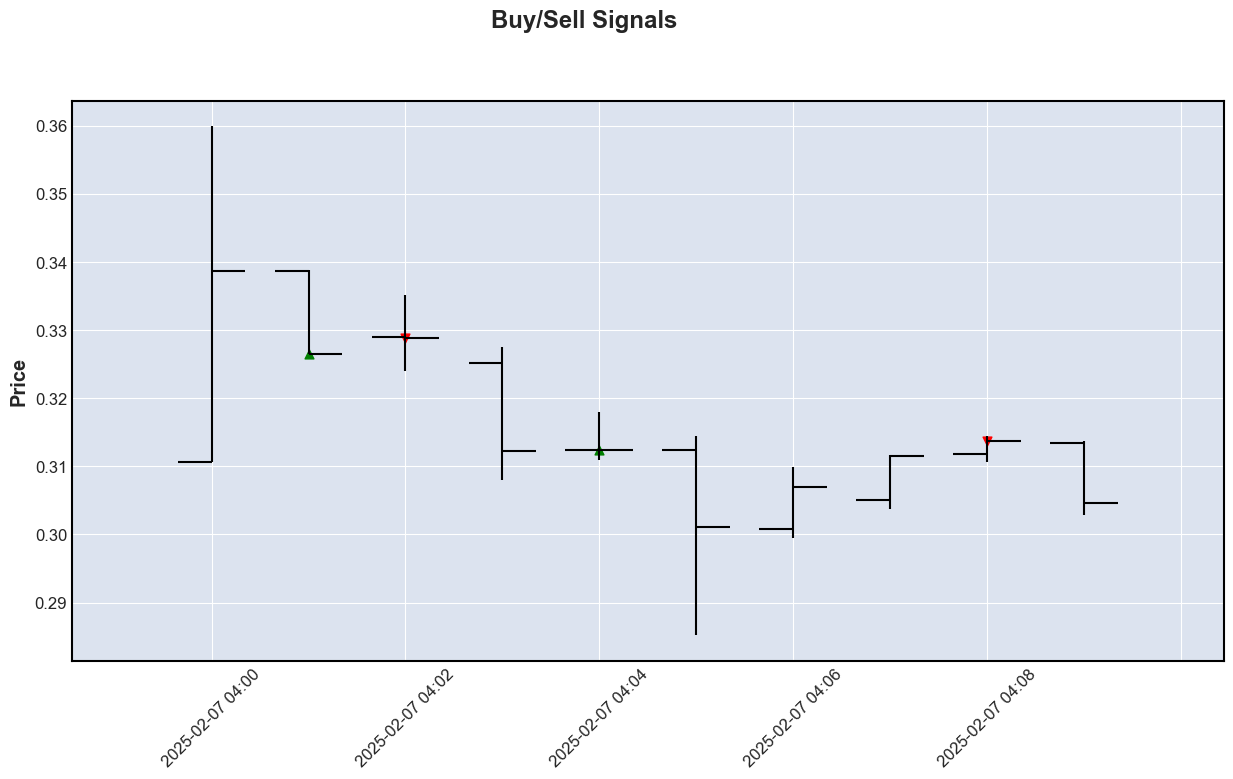

In [21]:
# Show learned buy and sell signals

import mplfinance as mpf
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame, buy_signals_1000, sell_signals_1000, buy_signals_10000, and sell_signals_10000 are your lists of timestamps

# Function to plot the signals for a given buy and sell signal list
def plot_signals(buy_signals, sell_signals, title):
    # Convert buy/sell signals to DatetimeIndex
    buy_signals = pd.to_datetime(buy_signals)  
    buy_signals = buy_signals[buy_signals.isin(df_original.index)]  # Filter buy signals to match df.index

    sell_signals = pd.to_datetime(sell_signals)  
    sell_signals = sell_signals[sell_signals.isin(df_original.index)]  # Filter sell signals to match df.index

    # Create new columns to mark the buy and sell signals with NaN for non-signals
    buy_signal_prices = df_original['close'].copy()
    buy_signal_prices[~df_original.index.isin(buy_signals)] = float('nan')  # Set non-buy signals to NaN
    
    sell_signal_prices = df_original['close'].copy()
    sell_signal_prices[~df_original.index.isin(sell_signals)] = float('nan')  # Set non-sell signals to NaN

    # Create addplots for buy and sell signals
    buy_signal_plot = mpf.make_addplot(buy_signal_prices, type='scatter', markersize=40, marker='^', color='green')
    sell_signal_plot = mpf.make_addplot(sell_signal_prices, type='scatter', markersize=40, marker='v', color='red')

    # Plot with the added buy and sell signals
    fig, axes = mpf.plot(
        df_original,
        type='ohlc',
        datetime_format='%Y-%m-%d %H:%M',
        addplot=[buy_signal_plot, sell_signal_plot],
        returnfig=True,
        figsize=(16, 8),
        warn_too_much_data=10000,
        title=title #Adjust the size again to maintain consistency
    )

plot_signals(buy_signals, sell_signals, title="Buy/Sell Signals")


In [ ]:
# Function to calculate profit based on buy and sell signals
def calculate_profit(buy_signals, sell_signals, df):
    buy_prices = df.loc[buy_signals, 'close']
    sell_prices = df.loc[sell_signals, 'close']

    # Ensure that the number of buy signals is less than or equal to the number of sell signals
    min_length = min(len(buy_prices), len(sell_prices))

    # Calculate profit for each pair of buy and sell signals
    profits = []
    for i in range(min_length):
        profit = sell_prices.iloc[i] - buy_prices.iloc[i]  # Profit = Sell Price - Buy Price
        profits.append(profit)

    total_profit = sum(profits)
    return total_profit, profits

# Function to plot the signals and compare profits
def plot_signals_and_compare_profit(buy_signals, sell_signals, df, title):
    # Convert buy/sell signals to DatetimeIndex
    buy_signals = pd.to_datetime(buy_signals)  
    buy_signals = buy_signals[buy_signals.isin(df.index)]  # Filter buy signals to match df.index

    sell_signals = pd.to_datetime(sell_signals)  
    sell_signals = sell_signals[sell_signals.isin(df.index)]  # Filter sell signals to match df.index

    # Create new columns to mark the buy and sell signals with NaN for non-signals
    buy_signal_prices = df['close'].copy()
    buy_signal_prices[~df.index.isin(buy_signals)] = float('nan')  # Set non-buy signals to NaN

    sell_signal_prices = df['close'].copy()
    sell_signal_prices[~df.index.isin(sell_signals)] = float('nan')  # Set non-sell signals to NaN

    # Create addplots for buy and sell signals
    buy_signal_plot = mpf.make_addplot(buy_signal_prices, type='scatter', markersize=40, marker='^', color='green')
    sell_signal_plot = mpf.make_addplot(sell_signal_prices, type='scatter', markersize=40, marker='v', color='red')

    # Plot with the added buy and sell signals
    fig, axes = mpf.plot(
        df,
        type='ohlc',
        style='charles',
        datetime_format='%Y-%m-%d %H:%M',
        addplot=[buy_signal_plot, sell_signal_plot],
        returnfig=True,
        figsize=(20, 10),
        warn_too_much_data=1000  # Adjust the size again to maintain consistency
    )

    # Customize x-axis
    #axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    #plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    # Add legend manually
    #plt.legend(['Buy Signals', 'Sell Signals'], loc='upper left')

    # Add title
    #plt.title(title)

    # Show the plot
    #plt.show()

    # Calculate and print profit for the signals
    total_profit, profits = calculate_profit(buy_signals, sell_signals, df)
    print(f"Total Profit for {title}: {total_profit:.2f}")
    return total_profit

# Calculate and plot for 1000 timesteps signals
profit_1000 = plot_signals_and_compare_profit(buy_signals_1000, sell_signals_1000, df, title="Profit for 1000 Timesteps")

# Calculate and plot for 10000 timesteps signals
profit_10000 = plot_signals_and_compare_profit(buy_signals_10000, sell_signals_10000, df, title="Profit for 10000 Timesteps")

# Calculate and plot for 100000 timesteps signals
#profit_100000 = plot_signals_and_compare_profit(buy_signals_100000, sell_signals_100000, df, title="Profit for 100000 Timesteps")


# Compare the total profits
print(f"Total Profit for 1000 Timesteps: {profit_1000:.2f}")
print(f"Total Profit for 10000 Timesteps: {profit_10000:.2f}")
#print(f"Total Profit for 100000 Timesteps: {profit_100000:.2f}")